### 1.1 Librerías

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import accuracy

### 1.2. Lectura de datos

In [3]:
# Se lee el dataset
data = pd.read_csv("supermercados.csv")

In [4]:
#Eliminar nulos
df = data.dropna()

#Convertir el codigo a int
df['codigosap'] = df['codigosap'].astype('int64')

#Seleccionar solo columnas importantes
df = df[['CodCliente', 'NombreCliente','Categoria','Subcategoria','codigosap','descripcion','Cantidad','PrecioUnitario', 'ImporteLinea']]

#Detalles de data
print('Dimension: ', df.shape)
df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_6360\491049900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['codigosap'] = df['codigosap'].astype('int64')


Dimension:  (5640082, 9)


,CodCliente,NombreCliente,Categoria,Subcategoria,codigosap,descripcion,Cantidad,PrecioUnitario,ImporteLinea
0,3546436,CAREAGA CHIRE RAMIRO ALEJANDRO,SALUD SEXUAL,PRESERVATIVOS,10105823,PRESERVATIVO MAXMEN BOOM 3UN,1.0,12.9,12.9
1,647917,TORREZ LUNARIO AMMY,PAPELES DESECHABLES,SERVILLETAS,10065383,SERVILLETA ELITE COCTEL 400UN,1.0,29.9,29.9
2,647917,TORREZ LUNARIO AMMY,BEBIDAS LACTEAS,YOGURT NATURAL/GRIEG,107313,YOGURT FATYH NATURAL 500 ML,1.0,8.9,8.9
3,647917,TORREZ LUNARIO AMMY,AZUCAR,AZUCAR MORENA,10109269,AZUCAR AGUAI MORENA 1 KG,1.0,5.5,5.5
4,647917,TORREZ LUNARIO AMMY,AZUCAR,AZUCAR BLANCA,10004437,AZUCAR GUABIRA EXTRA FINA 5KG,1.0,25.5,25.5


# Eliminación de datos

## Eliminando clientes con demasiadas apariciones

In [10]:
#Clientes por cantidad de compras que han hecho
aparXcliente = df.groupby('CodCliente').size().reset_index(name='Apariciones')

totApar = aparXcliente['Apariciones'].sum()
aparXcliente['Porcentaje'] = round(aparXcliente['Apariciones'] / totApar * 100, 4)

aparXcliente = aparXcliente.sort_values(by='Apariciones', ascending=False)
aparXcliente.head()

,CodCliente,Apariciones,Porcentaje
0,0,2712826,48.0991
34246,9109926,11744,0.2082
188,123456,8561,0.1518
25151,4904910,6007,0.1065
7243,2375252,5874,0.1041


In [12]:
#Clientes por variedad de productos
prdoXcliente = df.groupby('CodCliente')['codigosap'].nunique().reset_index()
prdoXcliente.rename(columns={'codigosap': 'Cantidad'}, inplace=True)

#Agregando columna de porcentaje
totCant = prdoXcliente['Cantidad'].sum()
prdoXcliente['Porcentaje'] = round((prdoXcliente['Cantidad'] / totCant) * 100,4)

prdoXcliente.head()

,CodCliente,Cantidad,Porcentaje
0,0,24798,1.3368
1,1,27,0.0015
2,2,9,0.0005
3,4,24,0.0013
4,9,1,0.0001


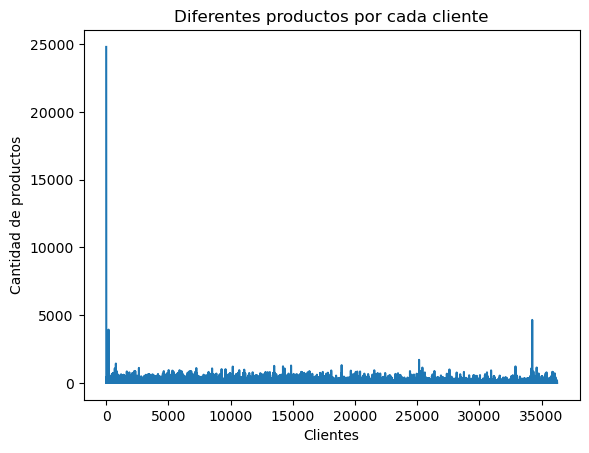

In [14]:
L = list(prdoXcliente['Cantidad'])
plt.plot(L)
plt.title('Diferentes productos por cada cliente')
plt.xlabel('Clientes')
plt.ylabel('Cantidad de productos')
plt.show()

In [16]:
#Eliminando los clientes que compraron demasiados productos
df = df[(df['CodCliente'] != 0) & (df['CodCliente'] != 123456) & (df['CodCliente'] != 9109926)]

print('Nro de clientes', len(df['CodCliente'].unique()))
print('Nro de productos', len(df['codigosap'].unique()))

Nro de clientes 36246
Nro de productos 24854


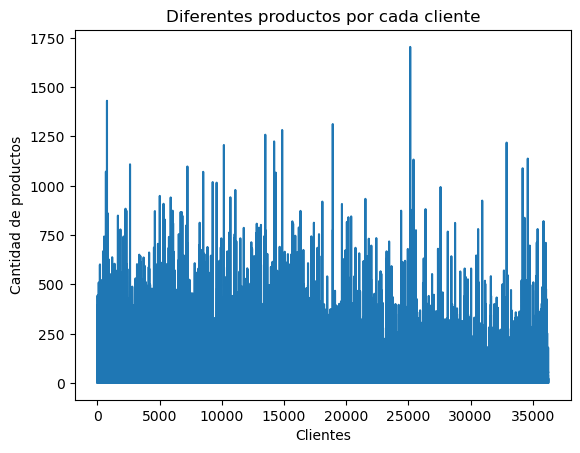

In [18]:
L = list(df.groupby('CodCliente')['codigosap'].nunique().reset_index()['codigosap'])
plt.plot(L)
plt.title('Diferentes productos por cada cliente')
plt.xlabel('Clientes')
plt.ylabel('Cantidad de productos')
plt.show()

In [20]:
df.shape

(2906951, 9)

In [22]:
nevativos = df[df['ImporteLinea'] <= 0].shape[0]

print(f"Cantidad de Devoluciones: {nevativos}")
print(f"Porcentaje de la data: {nevativos*100/df.shape[0]}%")

Cantidad de Devoluciones: 1534
Porcentaje de la data: 0.05277006733171629%


In [24]:
#Elimnando los registros de devoluciones
df = df[df['ImporteLinea'] > 0]

In [26]:
df.shape

(2905417, 9)

In [28]:
df.columns

Index(['CodCliente', 'NombreCliente', 'Categoria', 'Subcategoria', 'codigosap',
       'descripcion', 'Cantidad', 'PrecioUnitario', 'ImporteLinea'],
      dtype='object')

# Filtrado de datos: Filtrar productos o clientes con pocas compras para evitar sesgos.

In [31]:
#Filtrar productos con pocas compras (menor a 5 compras)
product_counts = df['codigosap'].value_counts()
min_product_purchases = 5  # umbral mínimo de compras por producto
filtered_products = product_counts[product_counts >= min_product_purchases].index
df_filtered_products = df[df['codigosap'].isin(filtered_products)]

#Filtrar clientes con pocas compras (menor a 5 compras)
client_counts = df_filtered_products['CodCliente'].value_counts()
min_client_purchases = 5  # umbral mínimo de compras por cliente
filtered_clients = client_counts[client_counts >= min_client_purchases].index
df_filtered = df_filtered_products[df_filtered_products['CodCliente'].isin(filtered_clients)]

#Tamaño del dataframe filtrado
df_filtered.shape

(2872497, 9)

# Algoritmo SVD: Filtrado Colaborativo

## Cálculo de ratings

In [35]:
df = df_filtered

In [37]:
# Calcular el número de compras por cliente y producto
purchase_counts = df.groupby(['CodCliente', 'codigosap']).size().reset_index(name='purchase_count')

# Usar el logaritmo de la frecuencia para calcular los ratings
purchase_counts['log_purchase_count'] = np.log1p(purchase_counts['purchase_count'])

# Ratings a la escala de 1 a 5
min_log_count = purchase_counts['log_purchase_count'].min()
max_log_count = purchase_counts['log_purchase_count'].max()
purchase_counts['rating'] = 1 + (purchase_counts['log_purchase_count'] - min_log_count) / (max_log_count - min_log_count) * 4

In [39]:
print(f"Min rating: {purchase_counts['rating'].min()}")  # Valor mínimo del rating
print(f"Max rating: {purchase_counts['rating'].max()}")  # Valor máximo del rating

Min rating: 1.0
Max rating: 5.0


In [45]:
#Se visualiza que los productos mayores a 100 pueden provocar sesgos debido al rating demasiado alto
purchase_counts[purchase_counts['purchase_count'] > 100].head()

,CodCliente,codigosap,purchase_count,log_purchase_count,rating
18719,134806,103817,157,5.062595,4.407044
20855,138537,200049,169,5.135798,4.464124
20877,138537,10000080,102,4.634729,4.073419
38087,229547,200041,125,4.836282,4.230578
96181,390755,100493,115,4.753590,4.166100


In [49]:
#Calcular el conteo de compras por producto
product_counts = df['codigosap'].value_counts()

#Filtrar productos con más de 100 compras por cliente
max_purchases_threshold = 100
filtered_products = product_counts[product_counts <= max_purchases_threshold].index

#Aplicar el filtro
purchase_counts = purchase_counts[purchase_counts['codigosap'].isin(filtered_products)]

In [51]:
# Convertir el dataframe a un formato surprise para el uso del filtrado colaborativo
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(purchase_counts[['CodCliente', 'codigosap', 'rating']], reader)

# Usar SVD para el filtrado colaborativo
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Recomendar productos para un cliente
def get_recommendations(user_id, algo, df, n=5):
    user_ratings = df[df['CodCliente'] == user_id]
    products = df['codigosap'].unique()
    products_already_rated = user_ratings['codigosap'].unique()
    products_to_predict = [x for x in products if x not in products_already_rated]
    predictions = [algo.predict(user_id, product_id) for product_id in products_to_predict]
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    return [(pred.iid, pred.est) for pred in recommendations]

user_id = 6143  # ID del cliente
recommendations = get_recommendations(user_id, algo, purchase_counts)
print(f'Recomendaciones para el cliente {user_id}: {recommendations}')

Recomendaciones para el cliente 6143: [(10118546, 1.5049600991125514), (10006566, 1.4378321512986703), (10125222, 1.4313149434419628), (10079060, 1.4301783164973831), (10117077, 1.4167875436126969)]


In [53]:
def obtener_descripcion(df, codigosap):
    descripcion = df[df['codigosap'] == codigosap]['descripcion'].iloc[0]
    return descripcion

print(f'Recomendaciones para el cliente {user_id}')
for codigosap, rating in recommendations:
    descripcion = obtener_descripcion(df, codigosap)
    print(f"Codigosap: {codigosap}, Descripción: {descripcion}, Rating: {rating}")

Recomendaciones para el cliente 6143
Codigosap: 10118546, Descripción: LECHE NIDO +3 1.6KG, Rating: 1.5049600991125514
Codigosap: 10006566, Descripción: CIGARRILLOS MARLBORO GOLD X20 UN        , Rating: 1.4378321512986703
Codigosap: 10125222, Descripción: DOGCHOW CCHR M/G S DBLPROTN 6X3KG, Rating: 1.4313149434419628
Codigosap: 10079060, Descripción: LAVANDINA DONA CLARITA DESINFECTANTE 5LT, Rating: 1.4301783164973831
Codigosap: 10117077, Descripción: FRASCO ALMACENAMIENTO 600ML 73-001      , Rating: 1.4167875436126969


In [55]:
cliente_df = df[df['CodCliente'] == user_id]
cliente_rates = purchase_counts[purchase_counts['CodCliente'] == user_id]

In [57]:
resultado = cliente_df.groupby('descripcion')['Cantidad'].sum().reset_index()
resultado = resultado.sort_values(by='Cantidad', ascending=False)
resultado.head()

,descripcion,Cantidad
249,PAN CHUKUTA KETAL UNIDAD,63.0
22,AGUA VITAL SIN GAS 2LT,28.0
198,LECHUGA MIXTA APROX 200GR,22.0
413,YOGURT GRIEGO DELIZIA FRESA 170GR,17.0
416,ZUMO SANTA MARIA NARANJA 1000ML,15.0
